In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
sess = tf.compat.v1.InteractiveSession()

Using TensorFlow backend.


In [2]:
# load the model
pretrained_model = VGG16(weights='imagenet', include_top=True)
pretrained_model.trainable = False

In [3]:
image_path = 'YellowLabradorLooking_new.jpg'

In [4]:
def preprocess_v2(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

In [5]:
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [6]:
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = tf.cast(image, tf.float32)
image = tf.image.resize(image, (224, 224))
image = image[None, ...]
img_numpy = image.numpy()
img_numpy = preprocess_input(img_numpy)
image = tf.convert_to_tensor(img_numpy)
# image

In [7]:
# image = image[None, ...]
# image

In [8]:
# image = preprocess_v2(image) #has the right data for adversarial code, but is classified as mosquito net by VGG16
# # image = image.numpy()
# # image = preprocess_input(image)
# image_numpy = image.numpy()
# image

In [10]:
image_probs = pretrained_model.predict(img_numpy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


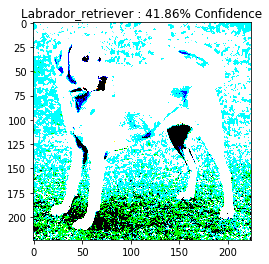

In [11]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [12]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [13]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0])
perturbations

<tf.Tensor 'Sign:0' shape=(1, 224, 224, 3) dtype=float32>

In [23]:
def display_images(image, description):
    #image = image.eval(session=sess) <----- tried evaluating with sessions but it says that the graphs aren't the same
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

In [24]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])


ValueError: Cannot use the given session to evaluate tensor: the tensor's graph is different from the session's graph.